# Assignment 7

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "EuroSAT" # replace with your path

2024-06-30 18:37:40.487361: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 18:37:40.489277: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 18:37:40.539471: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 18:37:40.904295: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 18:37:44.822528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [2]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    ## get list of the labes/subdirs (ignore the file '.DS_Store')
    labels = [dir for dir in os.listdir(path_to_data) if os.path.isdir(os.path.join(path_to_data, dir))]
    
    # initiate lists to hold image arrays
    images_array = []
    labels_array = []
    
    # loop through labels
    for label in labels:
        label_path = os.path.join(path_to_data, label)
        files = os.listdir(label_path)
        # loop through files in the subdirs and load the image data
        for file in files:
            image = load_img(os.path.join(label_path, file))
            image_array = img_to_array(image)
            images_array.append(image_array)
            labels_array.append(label)

    # convert lists to numpy arrays
    images = np.array(images_array)
    labels = np.array(labels_array)
    
    return images, labels

In [3]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

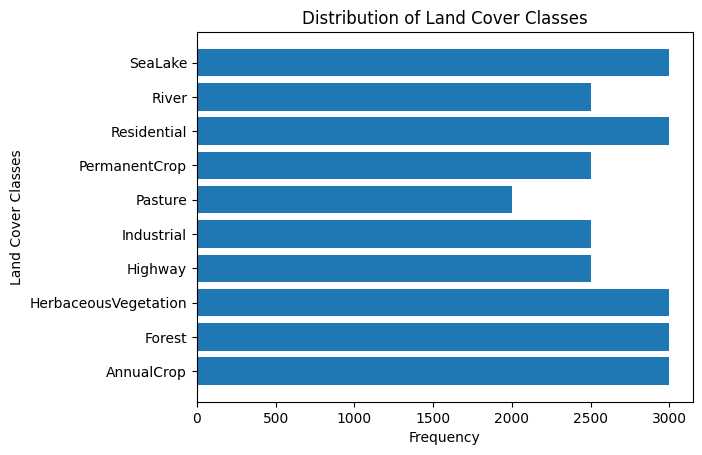

In [4]:
# get classes and frequency
hist_data = np.unique(labels, return_counts=True)

# create horizontal bar chart; labels are too long for vertical bars
plt.barh(hist_data[0], hist_data[1])
plt.xlabel('Frequency')
plt.ylabel('Land Cover Classes')
plt.title('Distribution of Land Cover Classes')
plt.show()

Comment on class balance: The classes are fairly balanced. There may be some slight under-representation for "Pasture" at 2,000 samples vs 2,500 and 3,000 for the others, but this is not a significant imbalance.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

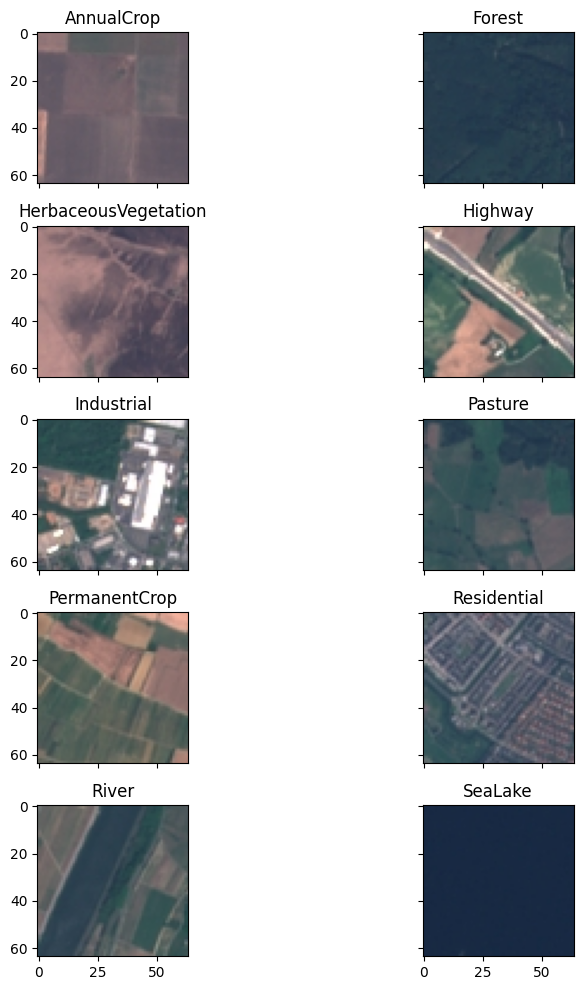

In [5]:
# set plot layout
n_rows = 5
n_cols = 2
fig, ax = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(10,10))

# get list of land cover labels
land_cover_list = hist_data[0]

# set counter for figure row and column
i = 0
j = 0

# loop through land cover labels
for lc in land_cover_list:
    lc_idx = np.where(labels == lc)[0][0]
    curr_img = images[lc_idx].astype(int)
    ax[i][j].imshow(curr_img)
    ax[i][j].set_title(lc)

    # increment column if within the figure bounds
    if j < n_cols - 1:
        j += 1
    else:
        i += 1
        j = 0

plt.tight_layout()
plt.show()



Most confused land classes: The classes "PermanentCrop" and "AnnualCrop" have potential for high confusion.

---
### Step 3: Data preprocessing

Encode labels

In [6]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [7]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. 
    # The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    shuffle = np.random.permutation(np.arange(labels.shape[0]))
    X, y = images[shuffle], labels[shuffle]
        
    # create data splits
    splits = np.multiply(len(y), split).astype(int)
    X_train, X_val, X_test = np.split(X, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [9]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, delta=DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X, contrast_factor=CONTRAST_FACTOR)

        # random flip
        X_augm = tf.image.flip_left_right(X)

        # concatenate original X and augmented X_aug data
        X = np.concatenate([X, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor
        
        
    # rescale image by dividing each pixel by 255.0 
    X = X / 255.0
    
    return X, y

Comment on the importnace of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): It is import to add augmented images to training because it increase the variance of the data and allows the model to train on different possible scenarios that we may face in production. We do not want to apply this to the validation and test, because we want our model to perform as though those sets are 'unseen'. We only want to fit the model to trainig data.

In [10]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [11]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

Accuracy on Train: 0.5162345679012346
Accuracy on Validation: 0.4727777777777778


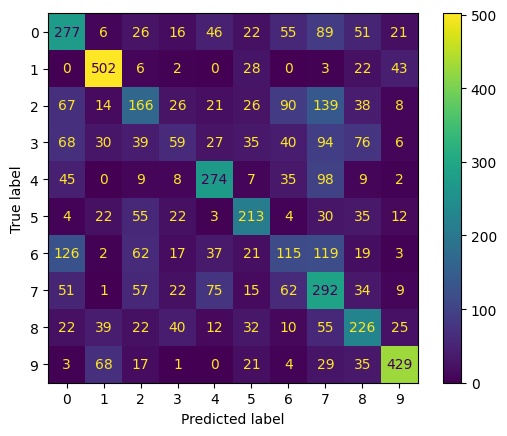

In [12]:
# create baseline random forest model
baseline = ensemble.RandomForestClassifier(n_estimators=2,
                                           random_state=7,
                                           n_jobs=1,
                                           max_depth=8)

# train the model
baseline.fit(X_train_re, y_train)

# print the accuracies for Train and Validation
print ('Accuracy on Train:', baseline.score(X_train_re, y_train))
print ('Accuracy on Validation:', baseline.score(X_val_re, y_val))

# get predictions for Val
y_val_pred = baseline.predict(X_val_re)

# print confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()


Comment on model accuracy on training vs. validation data: The model does not have good accuracy for either the train or validation sets at 52% and 47%, respectively.

Does the model generalize well?: The model has poor accuracy for the train and validation, and we can see that the validation accuracy is just below the training accuracy. This model does not generalize well.

Comment on the classes that the model confuses the most: The model confuses the "Highway" images the most, and only correctly classifies 59 of the 474 (12%) images and erroneously classifies 139 (29%) as "Residential". The model also confuses "PermanentCrop" with only 115 of the 521 (22%) being classified correctly, 24% were confused for "AnnualCrop" and 23% were confused for "Residential". 

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the training and validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). Also, the performance difference between the training and validation sets should be at most 10%. Be sure to follow these guidelines: 
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

Accuracy on Train: 0.6356481481481482
Accuracy on Validation: 0.5788888888888889


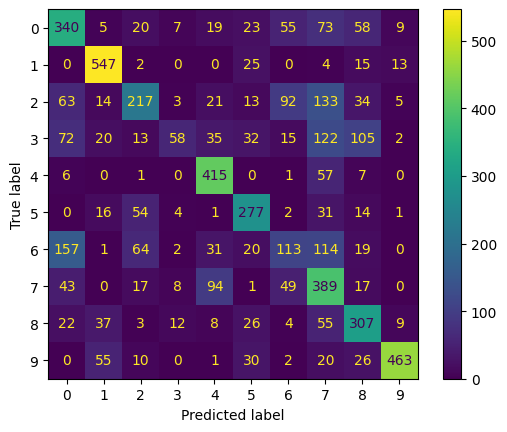

In [13]:
# compile RandomForest
rf_clf2 = ensemble.RandomForestClassifier(n_estimators=100,
                                           random_state=7,
                                           n_jobs=2,
                                           max_depth=8)

# rf_clf2 = ensemble.GradientBoostingClassifier(n_estimators=1,
#                                               learning_rate=1.0,
#                                               max_depth=3,
#                                               random_state=0)

# train the model
rf_clf2.fit(X_train_re, y_train)

# print the accuracies for Train and Validation
print ('Accuracy on Train:', rf_clf2.score(X_train_re, y_train))
print ('Accuracy on Validation:', rf_clf2.score(X_val_re, y_val))

# get predictions for Val
y_val_pred = rf_clf2.predict(X_val_re)

# print confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()


How your implementation is different compared to the baseline classifier: We tested many different levels of parameters within the RandomForestClassifier and the final version has a different number of estimators at 100. We tested higher depth which gave us higher accuracy for the train set but created much more overfitting.

Comment on training vs. validation performance relative to baseline model: The new model is an improvement over the baseline, with the accuracy for the training set growing from 52% to 64% (or 23% improvement) and the validation set growing from 47% to 58% (or 23% improvement)

Comment on the classes the model confuses the most relative to the baseline: The model still confuses "Highway" and only gets 58 of the 474 (12%) images correct. Additionally, the new model still confuses "PermanentCrop" and only gets 113 or the 521 (22%) correct. 

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the training and validation sets?

In [14]:
# Evaluate model for Test
y_test_pred = rf_clf2.predict(X_test_re)

print('Test, misclassified examples: %d' % (y_test != y_test_pred).sum())
error_test_tf = (y_test != y_test_pred).sum()/len(y_test_pred)
print('Test, prediction accuracy: %.3f'% (1-error_test_tf))


Test, misclassified examples: 2286
Test, prediction accuracy: 0.577


Comment on test set accuracy vs. training vs. validation set accuracy: The test set has the same accuracy as the validation set at 57% which is below the accuracy of the training set (64%)

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

In [15]:
print("""
Decision Forests have poor generalization which make them relatively weak models for
classifying detailed and complex images. The overfitting means that the model does 
not do a great job at adapting to new data when placed out in production. For this 
exercise, to get higher accuracy, we need to increase the depth of the trees, however
this increases the overfitting/decreases the ability to generalize.
""")


Decision Forests have poor generalization which make them relatively weak models for
classifying detailed and complex images. The overfitting means that the model does 
not do a great job at adapting to new data when placed out in production. For this 
exercise, to get higher accuracy, we need to increase the depth of the trees, however
this increases the overfitting/decreases the ability to generalize.



#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

In [16]:
print("""
A deep neural network using a convultional matrix ("Convolutional Neural Network" or "CNN")
will do a much better job for this exercise. The CNN applies a matrix transformation 
which will help the model better identify edges and other defining characteristics within the
images. This approach will allow for much more transformations of the data which will create 
a separation of the data points.
""")


A deep neural network using a convultional matrix ("Convolutional Neural Network" or "CNN")
will do a much better job for this exercise. The CNN applies a matrix transformation 
which will help the model better identify edges and other defining characteristics within the
images. This approach will allow for much more transformations of the data which will create 
a separation of the data points.



---
#### <span style="color:chocolate"> Bonus question (20 points) </span>

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

Epoch 1/5
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 94s 92ms/step - accuracy: 0.4274 - loss: 1.4907 - val_accuracy: 0.6735 - val_loss: 0.9197
Epoch 2/5
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 98s 97ms/step - accuracy: 0.7113 - loss: 0.7970 - val_accuracy: 0.7593 - val_loss: 0.6585
Epoch 3/5
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 112s 111ms/step - accuracy: 0.7683 - loss: 0.6529 - val_accuracy: 0.7613 - val_loss: 0.6810
Epoch 4/5
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 81s 80ms/step - accuracy: 0.7913 - loss: 0.5848 - val_accuracy: 0.7700 - val_loss: 0.6749
Epoch 5/5
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 118s 117ms/step - accuracy: 0.8147 - loss: 0.5201 - val_accuracy: 0.7804 - val_loss: 0.6285
169/169 - 7s - 42ms/step - accuracy: 0.7904 - loss: 0.5903
Accuracy on test data = 0.7903703451156616

The new CNN model has training accuracy of 81% and 82% accuracy on the test data.
This suggests that the CNN model does a good job generalizing. There is still room
for improvement by altering the structure of the model.



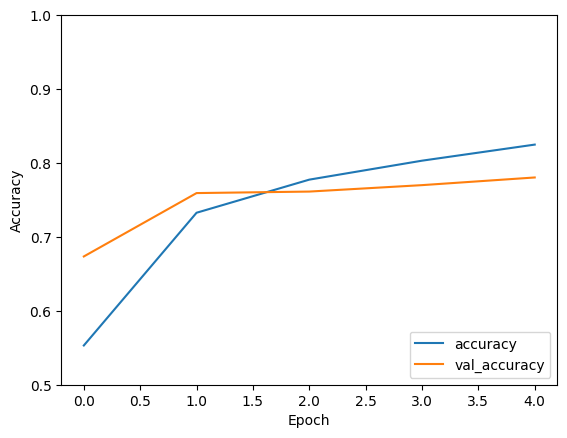

In [17]:
from tensorflow.keras import datasets, layers, models

# create model and add convolutional layers
new_model = models.Sequential()
new_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1:])))
new_model.add(layers.MaxPooling2D((2, 2)))
new_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
new_model.add(layers.MaxPooling2D((2, 2)))
new_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# add output layer
new_model.add(layers.Flatten())
new_model.add(layers.Dense(64, activation='relu'))
new_model.add(layers.Dense(10))

# compile and train model
new_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = new_model.fit(X_train
                    ,y_train
                    ,epochs=5
                    ,validation_data=(X_val, y_val))

# plot performance
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# get test accuracy
test_loss, test_acc = new_model.evaluate(X_test,  y_test, verbose=2)
print(f'Accuracy on test data = {test_acc}')

print(f"""
The new CNN model has training accuracy of 81% and 82% accuracy on the test data.
This suggests that the CNN model does a good job generalizing. There is still room
for improvement by altering the structure of the model.
""")